In [1]:
import json

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.transforms import v2

from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

2024-12-24 15:51:53.893685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 15:51:53.902331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8463] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 15:51:53.904978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cuda:0


In [2]:
import sys
sys.path.append("/home/user/Image-AdvAttack-2.0/")

In [3]:
import masks
from exp_base import get_accuracy, train, plot_probs, init_image

In [4]:
output = {
    "num_classes": [],
    "acc": [],
    "probs": [],
    "epochs": []
}

In [10]:
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

NUM_CLASSES = range(2, 65, 8)
BATCH_SIZE = 128  
IMAGE_SIZE = 64
EPOCHS = 5000
MASK = masks.MaskImageAll
# CRITERION = FocalLoss(gamma=1) 
CRITERION = nn.CrossEntropyLoss()

# writer = SummaryWriter(f"runs/experiment 1", comment=f"{BATCH_SIZE=}\n{IMAGE_SIZE=}\n{EPOCHS=}\n{MASK.__name__=}\n{CRITERION.__class__.__name__=}")
print(f"Running experiment 1")

for num_classes in NUM_CLASSES:
    univ_image = init_image(IMAGE_SIZE)
    
    print(f"---------- num_classes={num_classes} ----------")
    
    univ_image, epochs = train(
        model=model,
        univ_image=univ_image,
        epochs=EPOCHS,
        batch_size=num_classes,
        num_classes=num_classes,
        criterion=CRITERION,
        mask=MASK,
        writer=None
    )
    
    acc, probs = get_accuracy(model, univ_image, num_classes, MASK)
    
    output["num_classes"].append(num_classes)
    output["acc"].append(acc /  num_classes)
    output["probs"].append(probs)
    output["epochs"].append(epochs)

with open("result_maskall.json", "w") as f:
    json.dump(output, f)

Running experiment 1
---------- num_classes=2 ----------
EPOCH = 0/5000 | loss = 59.8541374206543 | acc=0.0 | lr=0.1 | time=0:0
CLOSING EPOCH = 254/5000 | loss = 1.943477749824524 | acc=1.0 | lr=0.1 | time=0:0
---------- num_classes=10 ----------
EPOCH = 0/5000 | loss = 49.03732681274414 | acc=0.0 | lr=0.1 | time=0:0
CLOSING EPOCH = 428/5000 | loss = 0.4610678553581238 | acc=1.0 | lr=0.1 | time=0:0
---------- num_classes=18 ----------
EPOCH = 0/5000 | loss = 50.96127700805664 | acc=0.0 | lr=0.1 | time=0:0
EPOCH = 500/5000 | loss = 5.054586410522461 | acc=0.1111111111111111 | lr=0.1 | time=0:9
EPOCH = 1000/5000 | loss = 4.3137922286987305 | acc=0.2222222222222222 | lr=0.1 | time=0:9
EPOCH = 1500/5000 | loss = 3.5242459774017334 | acc=0.2222222222222222 | lr=0.1 | time=0:9
EPOCH = 2000/5000 | loss = 2.8433330059051514 | acc=0.3888888888888889 | lr=0.1 | time=0:9
EPOCH = 2500/5000 | loss = 2.335954427719116 | acc=0.5 | lr=0.1 | time=0:9
EPOCH = 3000/5000 | loss = 2.033827781677246 | acc=0

In [34]:
ans = []
for prob_array in output["probs"]:
    cur_ans = [float(x) for x in prob_array]
    ans.append(cur_ans)
output["probs"] = ans
with open("./result.json", "w") as f:
    json.dump(output, f)

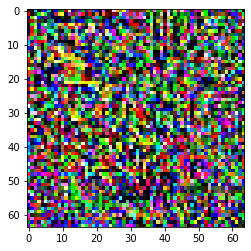

In [11]:
import matplotlib.pyplot as plt

plt.imshow((univ_image.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8))
plt.savefig("./univ_image_exp_6_alexnet_maskall.png")

dict_keys(['num_classes', 'acc', 'probs', 'epochs'])


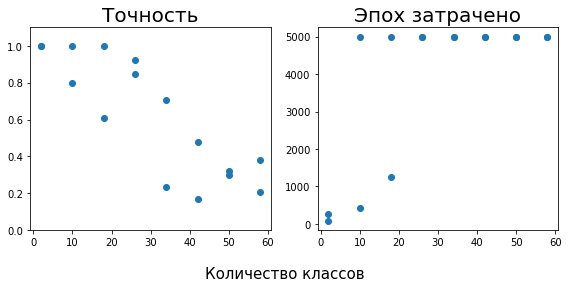

In [12]:
import matplotlib.pyplot as plt
import json

data = json.load(open("result_maskall.json", "r"))

print(data.keys())
fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="tight")
# fig.suptitle('Experiment 1 (mask all image by mask)', fontsize=20)
fig.supxlabel("Количество классов", fontsize=15)

ax[0].scatter(data["num_classes"], data["acc"])
# ax[0].set_xlabel("Количество классов")
ax[0].set_title("Точность", fontsize=20)
ax[0].set_ylim([0, 1.1])

ax[1].scatter(data["num_classes"], data["epochs"])
# ax[1].set_xlabel("Количество классов", fontsize=15)
ax[1].set_title("Эпох затрачено", fontsize=20)
plt.savefig("./exp6_alexnet_maskall_acc.png")
plt.show()

dict_keys(['num_classes', 'acc', 'probs', 'epochs'])
16


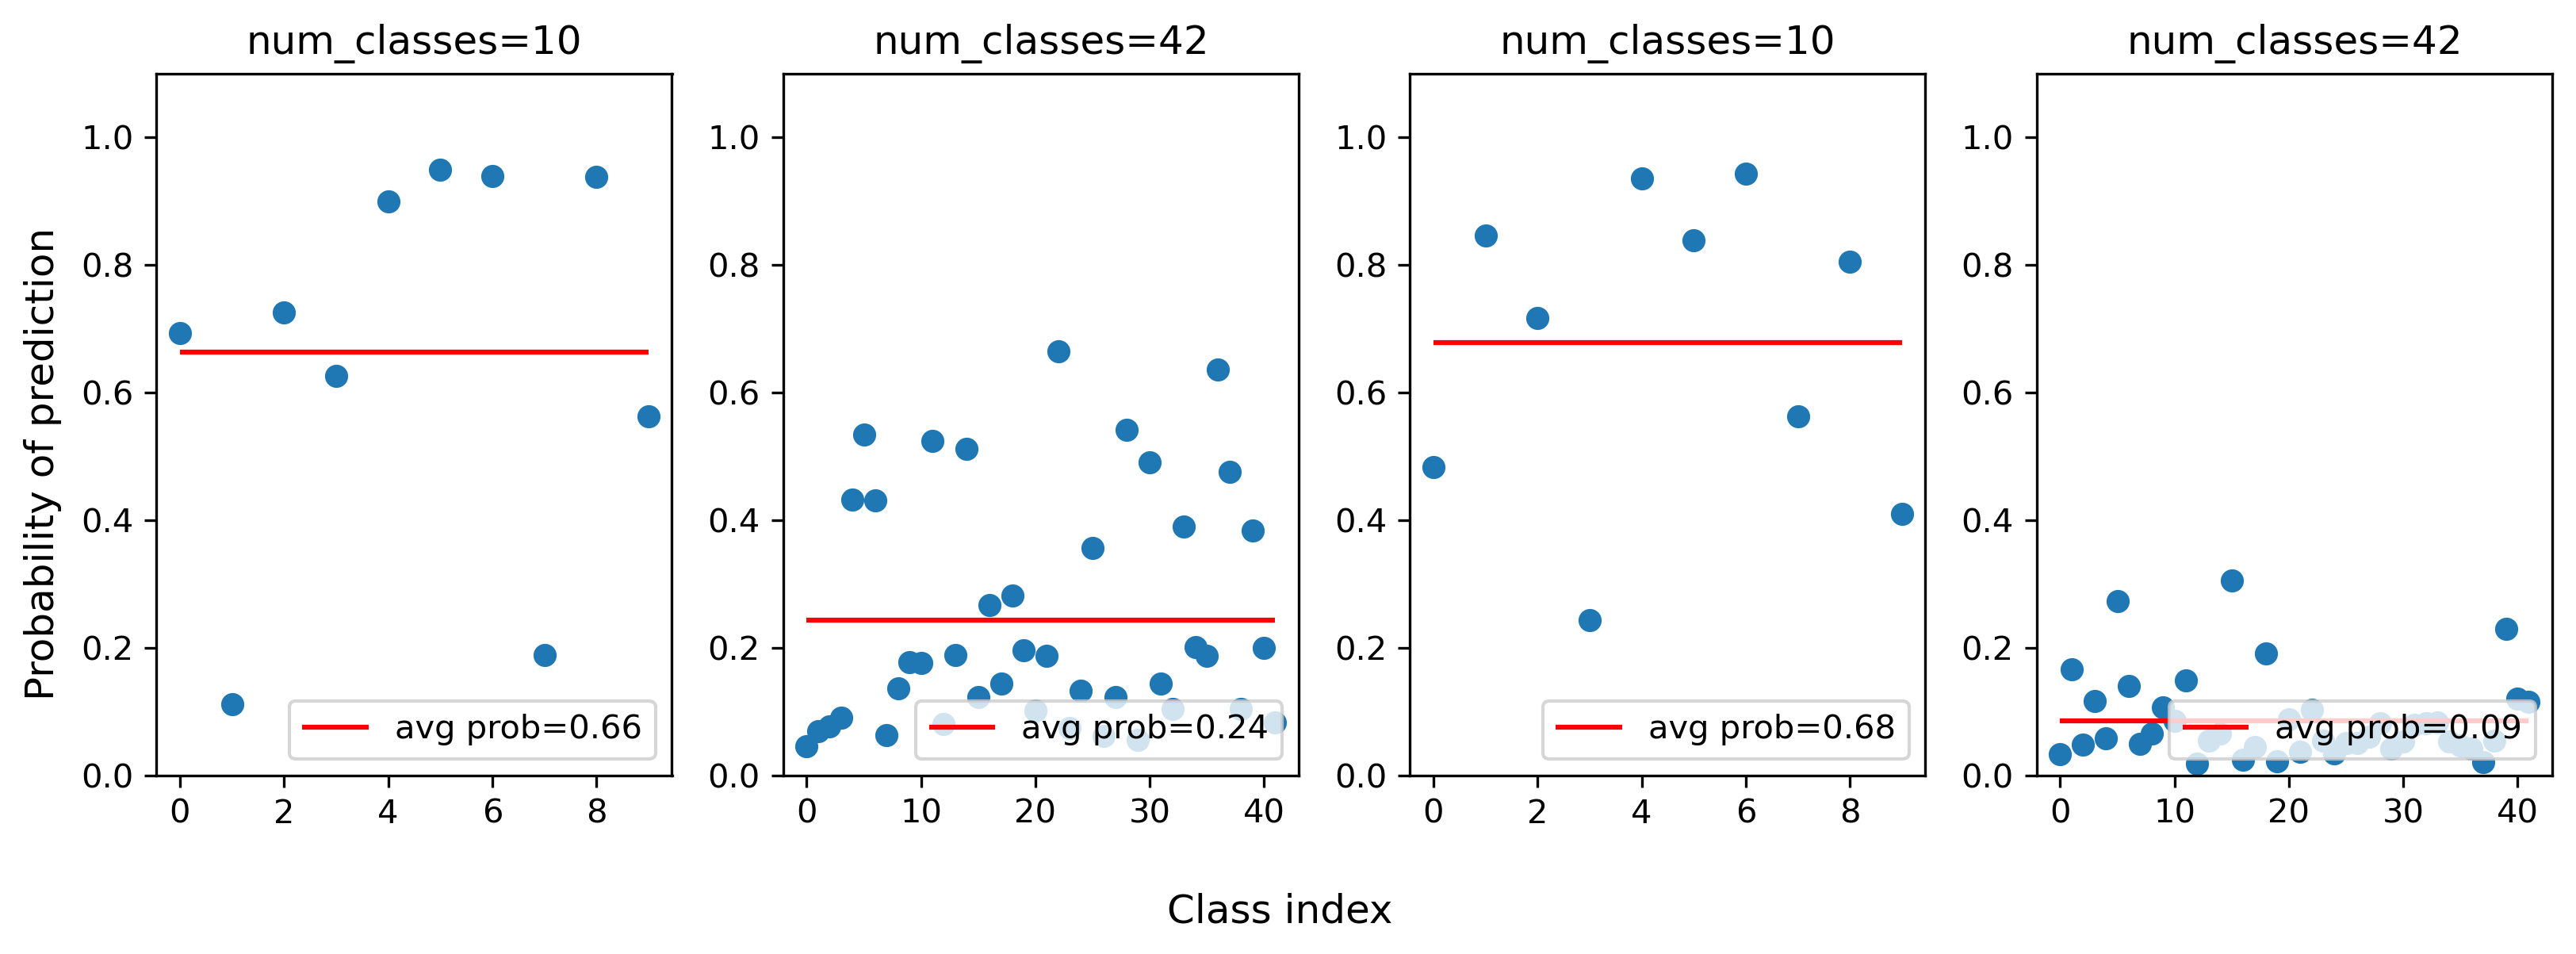

In [13]:
import matplotlib.pyplot as plt
import json

data = json.load(open("result_maskall.json", "r"))

print(data.keys())
print(len(data["probs"]))
fig, ax = plt.subplots(1, 4, figsize=(11, 4), layout='tight')
# fig.suptitle('Experiment 2 (mask by horizontal lines) - probs of predictions', fontsize=20)

k = 0
for num_classes, probs_arr in zip(data["num_classes"][1::4], data["probs"][1::4]):
    # probs_arr = data["probs"][i]
    ax[k].hlines(y=sum(probs_arr)/len(probs_arr), xmin=0, xmax=num_classes-1, color='r', label=f"avg prob={round(sum(probs_arr)/len(probs_arr) ,2)}")
    ax[k].scatter(range(len(probs_arr)), probs_arr)
    ax[k].set_ylim([0, 1.1])
    ax[k].set_title(f"num_classes={num_classes}")
    ax[k].legend(loc='lower right')
    k += 1

fig.supylabel('Probability of prediction')
fig.supxlabel("Class index")
fig.set_dpi(300)
plt.savefig("./exp6_alexnet_maskall_probs.png")
plt.show()